In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
from models.video_classifier import VideoClassifier
import os

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

In [4]:
class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands):
        self.bands = bands

    def __call__(self, x):
        return x.view(12, self.bands, 9, 9).permute(1, 0, 2, 3)

def get_transform(bands, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if 4 < x.shape[0]:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x

In [5]:
large_tif_dir = '../../data/source_data/naive' #원천데이터 주소
bands = 4 #밴드 수
patch_size = 9

transform = get_transform(bands, scale_channels)

train_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = "../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = lambda box_number: not test_filter(box_number),
    patch_size = patch_size,
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file ="../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = test_filter,
    patch_size = patch_size,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

(Token_length, embedding) = (4×81, 12)

In [46]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, patch_size=9, num_bands=4, temp=12, num_classes=6, 
                 d_model=24, nhead=6, num_layers=5, dim_feedforward=96):
        super().__init__()
        self.patch_size = patch_size
        self.num_bands = num_bands
        self.temp = temp
        self.num_tokens = num_bands * patch_size * patch_size  # 4×81 = 324
        self.d_model = d_model  # 24로 조정

        # ** 입력 차원 변환 레이어 추가 (12 → 24) **
        self.input_projection = nn.Linear(temp, d_model)  # (12 → 24로 변환)

        # Positional Encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, d_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead,  
            dim_feedforward=dim_feedforward,  
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification Head (줄인 버전)
        self.fc = nn.Sequential(
            nn.Linear(self.num_tokens * d_model, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]

        # (batch, 4, 12, 9, 9) → (batch, 4×9×9, 12)
        x = x.view(batch_size, self.num_tokens, -1)  

        # ** 입력 차원 변환 (12 → 24) **
        x = self.input_projection(x)  # (batch, 324, 24)

        # Add Positional Encoding
        x = x + self.pos_embedding  

        # Transformer Encoder
        x = self.transformer(x)  

        # Flatten & Classification
        x = x.flatten(1)  # (batch, 324×24)
        x = self.fc(x)  # (batch, num_classes)

        return x

In [54]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, patch_size=9, num_bands=4, temp=12, num_classes=6, 
                 d_model=20, nhead=4, num_layers=5, dim_feedforward=96, dropout=0.1):
        super().__init__()
        self.patch_size = patch_size
        self.num_bands = num_bands
        self.temp = temp
        self.num_tokens = num_bands * patch_size * patch_size  # 4×81 = 324
        self.d_model = d_model  # 24로 조정

        # ** 입력 차원 변환 레이어 추가 (12 → 24) **
        self.input_projection = nn.Linear(temp, d_model)  # (12 → 24 변환)

        # Positional Encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, d_model))

        # ** Layer Normalization 추가 **
        self.norm1 = nn.LayerNorm(d_model)  

        # Transformer Encoder (Dropout 추가)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead,  
            dim_feedforward=dim_feedforward,  
            dropout=dropout,  # 🔥 Dropout 추가
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification Head (Dropout 추가)
        self.fc = nn.Sequential(
            nn.Linear(self.num_tokens * d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # 🔥 Dropout 추가!
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # 🔥 Dropout 추가!
            nn.Linear(128, num_classes)
        )

        # ** Layer Normalization 추가 **
        self.norm2 = nn.LayerNorm(num_classes)  

        # ** 가중치 초기화 **
        self.apply(self._init_weights)  

    def forward(self, x):
        batch_size = x.shape[0]

        # (batch, 4, 12, 9, 9) → (batch, 4×9×9, 12)
        x = x.view(batch_size, self.num_tokens, -1)  

        # ** 입력 차원 변환 (12 → 24) **
        x = self.input_projection(x)  # (batch, 324, 24)

        # Add Positional Encoding
        x = x + self.pos_embedding  

        # Transformer Encoder (입력 정규화 추가)
        x = self.norm1(x)  
        x = self.transformer(x)  

        # Flatten & Classification
        x = x.flatten(1)  # (batch, 324×24)
        x = self.fc(x)  # (batch, num_classes)

        # 출력 정규화
        x = self.norm2(x)  

        return x

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)  # Xavier 초기화
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)


In [55]:
model = TransformerModel(patch_size=9, num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()

lr = 1e-4
weight_decay = 1e-4  # 🔥 L2 Regularization 적용
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Transformer 모델 파라미터 개수: {total_params}")

Transformer 모델 파라미터 개수: 1728178


Epoch 1/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.41it/s]



Epoch [1/30], Train Loss: 1.2963, Train Accuracy: 49.92%, Val Loss: 0.9563, Val Accuracy: 61.81%



Epoch 2/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.99it/s]



Epoch [2/30], Train Loss: 0.8014, Train Accuracy: 71.52%, Val Loss: 0.7981, Val Accuracy: 69.34%



Epoch 3/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:17<00:00, 67.55it/s]



Epoch [3/30], Train Loss: 0.6741, Train Accuracy: 75.82%, Val Loss: 0.6707, Val Accuracy: 75.98%



Epoch 4/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:17<00:00, 68.38it/s]



Epoch [4/30], Train Loss: 0.5935, Train Accuracy: 78.58%, Val Loss: 0.6601, Val Accuracy: 76.00%



Epoch 5/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:18<00:00, 64.50it/s]



Epoch [5/30], Train Loss: 0.5379, Train Accuracy: 80.47%, Val Loss: 0.6187, Val Accuracy: 77.36%



Epoch 6/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:18<00:00, 64.43it/s]



Epoch [6/30], Train Loss: 0.4956, Train Accuracy: 82.14%, Val Loss: 0.6203, Val Accuracy: 77.15%



Epoch 7/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.18it/s]



Epoch [7/30], Train Loss: 0.4638, Train Accuracy: 83.23%, Val Loss: 0.6252, Val Accuracy: 77.41%



Epoch 8/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.26it/s]



Epoch [8/30], Train Loss: 0.4314, Train Accuracy: 84.44%, Val Loss: 0.6020, Val Accuracy: 78.28%



Epoch 9/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:18<00:00, 65.87it/s]



Epoch [9/30], Train Loss: 0.4027, Train Accuracy: 85.41%, Val Loss: 0.6254, Val Accuracy: 77.83%



Epoch 10/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.93it/s]



Epoch [10/30], Train Loss: 0.3807, Train Accuracy: 86.27%, Val Loss: 0.6296, Val Accuracy: 78.13%



Epoch 11/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.57it/s]



Epoch [11/30], Train Loss: 0.3598, Train Accuracy: 87.05%, Val Loss: 0.6147, Val Accuracy: 78.74%



Epoch 12/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 65.41it/s]



Epoch [12/30], Train Loss: 0.3374, Train Accuracy: 88.00%, Val Loss: 0.5910, Val Accuracy: 79.59%



Epoch 13/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.04it/s]



Epoch [13/30], Train Loss: 0.3179, Train Accuracy: 88.66%, Val Loss: 0.6038, Val Accuracy: 79.50%



Epoch 14/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 65.39it/s]



Epoch [14/30], Train Loss: 0.3000, Train Accuracy: 89.28%, Val Loss: 0.6389, Val Accuracy: 78.65%



Epoch 15/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 64.62it/s]



Epoch [15/30], Train Loss: 0.2850, Train Accuracy: 89.83%, Val Loss: 0.6337, Val Accuracy: 79.62%



Epoch 16/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 65.79it/s]



Epoch [16/30], Train Loss: 0.2653, Train Accuracy: 90.59%, Val Loss: 0.6764, Val Accuracy: 78.39%



Epoch 17/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 65.70it/s]



Epoch [17/30], Train Loss: 0.2507, Train Accuracy: 91.16%, Val Loss: 0.7201, Val Accuracy: 77.69%



Epoch 18/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.18it/s]



Epoch [18/30], Train Loss: 0.2364, Train Accuracy: 91.67%, Val Loss: 0.6603, Val Accuracy: 79.67%



Epoch 19/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 65.78it/s]



Epoch [19/30], Train Loss: 0.2226, Train Accuracy: 92.22%, Val Loss: 0.7032, Val Accuracy: 78.77%



Epoch 20/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 65.34it/s]



Epoch [20/30], Train Loss: 0.2089, Train Accuracy: 92.69%, Val Loss: 0.7019, Val Accuracy: 78.96%



Epoch 21/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.70it/s]



Epoch [21/30], Train Loss: 0.1973, Train Accuracy: 93.17%, Val Loss: 0.6808, Val Accuracy: 79.32%



Epoch 22/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.30it/s]



Epoch [22/30], Train Loss: 0.1866, Train Accuracy: 93.56%, Val Loss: 0.7364, Val Accuracy: 79.11%



Epoch 23/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:17<00:00, 67.10it/s]



Epoch [23/30], Train Loss: 0.1777, Train Accuracy: 93.92%, Val Loss: 0.7483, Val Accuracy: 78.80%



Epoch 24/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:17<00:00, 67.14it/s]



Epoch [24/30], Train Loss: 0.1671, Train Accuracy: 94.27%, Val Loss: 0.7459, Val Accuracy: 79.15%



Epoch 25/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.09it/s]



Epoch [25/30], Train Loss: 0.1584, Train Accuracy: 94.58%, Val Loss: 0.7719, Val Accuracy: 78.57%



Epoch 26/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.27it/s]



Epoch [26/30], Train Loss: 0.1455, Train Accuracy: 95.09%, Val Loss: 0.7799, Val Accuracy: 79.07%



Epoch 27/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.14it/s]



Epoch [27/30], Train Loss: 0.1429, Train Accuracy: 95.11%, Val Loss: 0.7940, Val Accuracy: 78.71%



Epoch 28/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.74it/s]



Epoch [28/30], Train Loss: 0.1350, Train Accuracy: 95.45%, Val Loss: 0.8328, Val Accuracy: 77.97%



Epoch 29/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.82it/s]



Epoch [29/30], Train Loss: 0.1265, Train Accuracy: 95.66%, Val Loss: 0.8182, Val Accuracy: 78.76%



Epoch 30/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.29it/s]



Epoch [30/30], Train Loss: 0.1209, Train Accuracy: 95.97%, Val Loss: 0.8363, Val Accuracy: 78.46%


train data


Evaluation Progress: 100%|███████████████████████████████████████████████████| 3502/3502 [00:52<00:00, 66.64it/s]


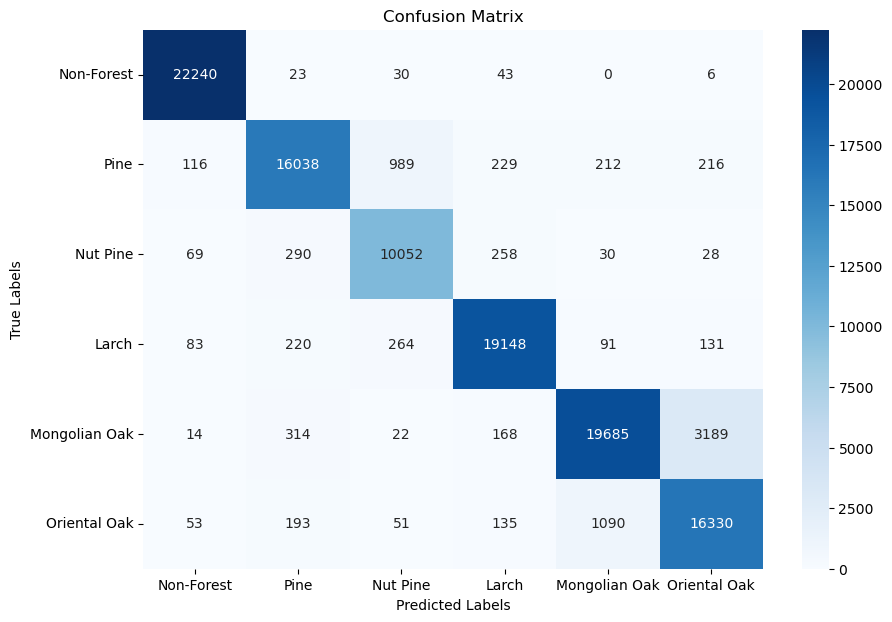

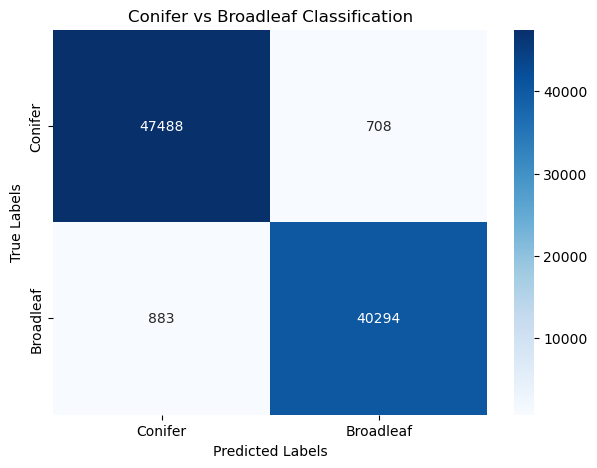

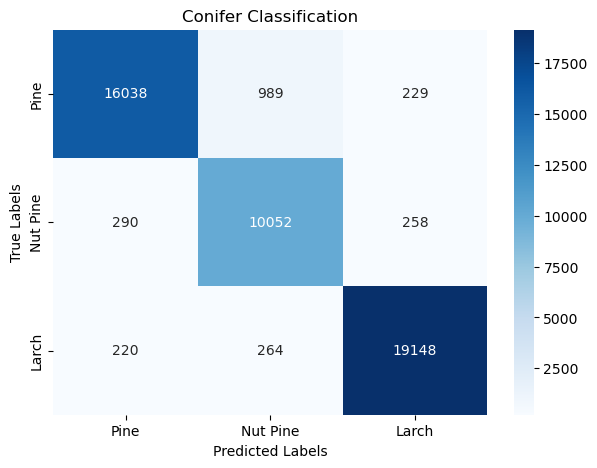

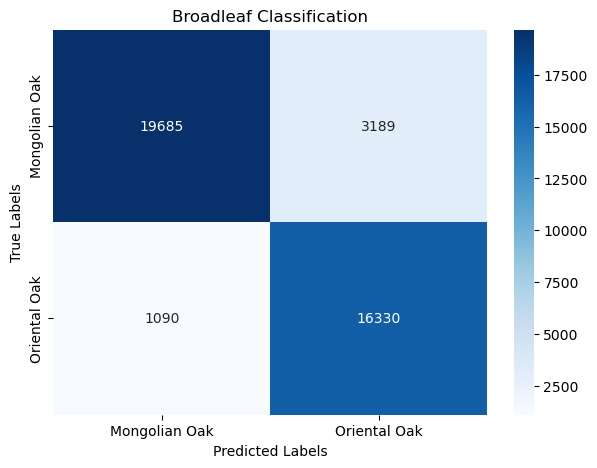


validation data


Evaluation Progress: 100%|███████████████████████████████████████████████████| 1207/1207 [00:18<00:00, 66.60it/s]


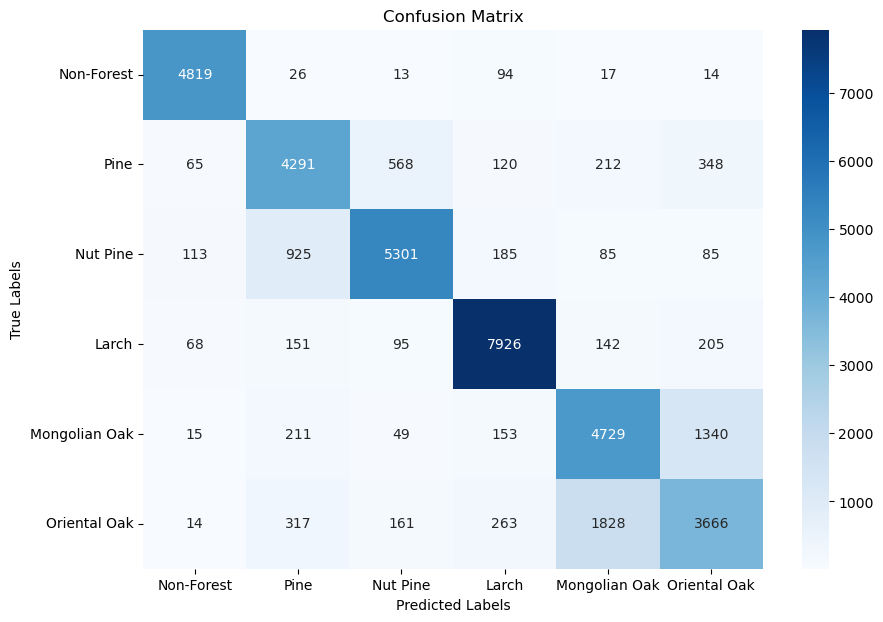

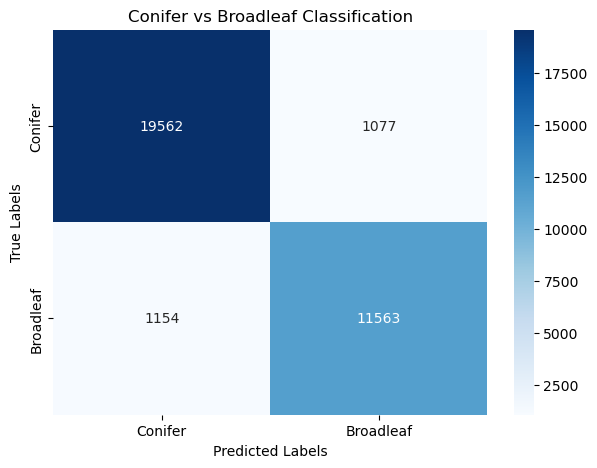

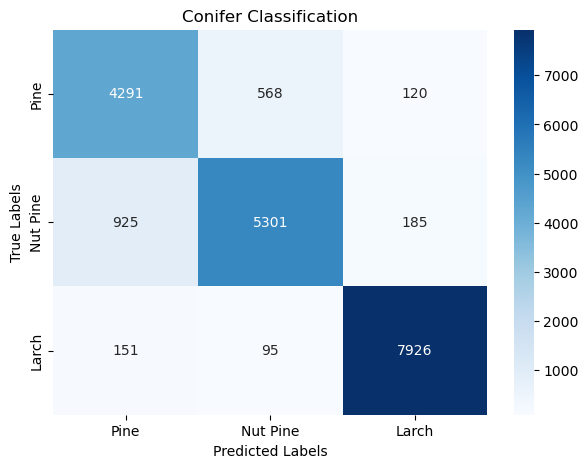

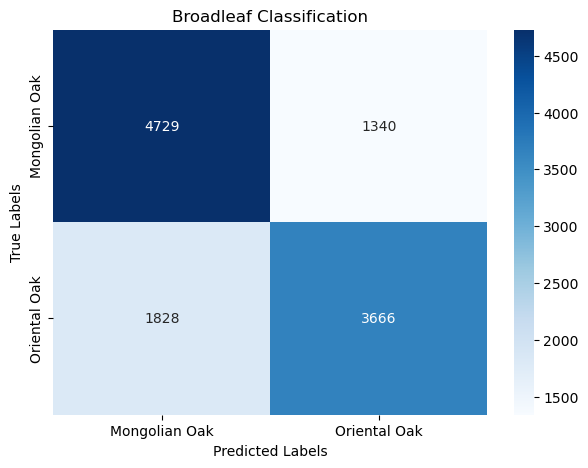

,precision,recall,f1-score,support,Category
Non-Forest,0.946015,0.967088,0.956435,4983.000000,Overall
Pine,0.724709,0.765703,0.744642,5604.000000,Overall
Nut Pine,0.856797,0.791903,0.823073,6694.000000,Overall
Larch,0.906761,0.923023,0.914820,8587.000000,Overall
Mongolian Oak,0.674319,0.727874,0.700074,6497.000000,Overall
Oriental Oak,0.647932,0.586654,0.615772,6249.000000,Overall
accuracy,0.795877,0.795877,0.795877,0.795877,Overall
macro avg,0.792755,0.793708,0.792469,38614.000000,Overall
weighted avg,0.795747,0.795877,0.795060,38614.000000,Overall
Conifer,0.944294,0.947817,0.946052,20639.000000,Conifer vs Broadleaf


In [56]:
num_epochs = 30

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100)
os.makedirs("./checkpoints/transformer", exist_ok=True)
torch.save(best_model_state, f"./checkpoints/transformer/transformer_{bands}_{patch_size}_{num_epochs}.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

(Token_length, embedding) = (12, 4×81)

In [57]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, patch_size=9, num_bands=4, temp=12, num_classes=6, 
                 d_model=64, nhead=4, num_layers=4, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.patch_size = patch_size
        self.num_bands = num_bands
        self.temp = temp
        self.num_tokens = temp  # 12개 (시계열 단위)
        self.d_model = d_model  

        # ** 입력 차원 변환 (4×9×9 → d_model) **
        self.input_projection = nn.Linear(num_bands * patch_size * patch_size, d_model)

        # Positional Encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, d_model))

        # ** Layer Normalization 추가 **
        self.norm1 = nn.LayerNorm(d_model)  

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead,  
            dim_feedforward=dim_feedforward,  
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification Head (Dropout 추가)
        self.fc = nn.Sequential(
            nn.Linear(self.num_tokens * d_model, 128),  # 192 → 128
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),  # 96 → 64
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

        # ** Layer Normalization 추가 **
        self.norm2 = nn.LayerNorm(num_classes)  

        # ** 가중치 초기화 **
        self.apply(self._init_weights)  

    def forward(self, x):
        batch_size = x.shape[0]

        # (batch, 4, 12, 9, 9) → (batch, 12, 4×9×9)
        x = x.permute(0, 2, 1, 3, 4).reshape(batch_size, self.num_tokens, -1)

        # 입력 차원 변환 (4×9×9 → d_model)
        x = self.input_projection(x)

        # Add Positional Encoding
        x = x + self.pos_embedding  

        # Transformer Encoder
        x = self.norm1(x)  
        x = self.transformer(x)  

        # Flatten & Classification
        x = x.flatten(1)  
        x = self.fc(x)

        # 출력 정규화
        x = self.norm2(x)  

        return x

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)  
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)


In [58]:
model = TransformerModel(patch_size=9, num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()

lr = 1e-4
weight_decay = 1e-4  # 🔥 L2 Regularization 적용
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Transformer 모델 파라미터 개수: {total_params}")

Transformer 모델 파라미터 개수: 262674


Epoch 1/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:09<00:00, 132.12it/s]



Epoch [1/30], Train Loss: 0.9862, Train Accuracy: 62.89%, Val Loss: 0.7232, Val Accuracy: 74.74%



Epoch 2/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:09<00:00, 129.12it/s]



Epoch [2/30], Train Loss: 0.6695, Train Accuracy: 76.57%, Val Loss: 0.6369, Val Accuracy: 76.10%



Epoch 3/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:09<00:00, 132.80it/s]



Epoch [3/30], Train Loss: 0.5728, Train Accuracy: 79.64%, Val Loss: 0.5606, Val Accuracy: 79.58%



Epoch 4/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:09<00:00, 132.24it/s]



Epoch [4/30], Train Loss: 0.5179, Train Accuracy: 81.50%, Val Loss: 0.5346, Val Accuracy: 81.33%



Epoch 5/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:09<00:00, 130.93it/s]



Epoch [5/30], Train Loss: 0.4792, Train Accuracy: 82.79%, Val Loss: 0.4954, Val Accuracy: 82.42%



Epoch 6/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:09<00:00, 132.09it/s]



Epoch [6/30], Train Loss: 0.4463, Train Accuracy: 84.00%, Val Loss: 0.4877, Val Accuracy: 82.74%



Epoch 7/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:09<00:00, 132.15it/s]



Epoch [7/30], Train Loss: 0.4245, Train Accuracy: 84.78%, Val Loss: 0.4449, Val Accuracy: 84.74%



Epoch 8/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:09<00:00, 131.37it/s]



Epoch [8/30], Train Loss: 0.4024, Train Accuracy: 85.53%, Val Loss: 0.4601, Val Accuracy: 83.86%



Epoch 9/30 - Validation: 100%|██████████████████████████████████████████████| 1207/1207 [00:09<00:00, 133.62it/s]



Epoch [9/30], Train Loss: 0.3878, Train Accuracy: 86.12%, Val Loss: 0.4287, Val Accuracy: 85.11%



Epoch 10/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 129.46it/s]



Epoch [10/30], Train Loss: 0.3734, Train Accuracy: 86.65%, Val Loss: 0.4927, Val Accuracy: 82.84%



Epoch 11/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 128.94it/s]



Epoch [11/30], Train Loss: 0.3593, Train Accuracy: 87.26%, Val Loss: 0.4271, Val Accuracy: 85.33%



Epoch 12/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 132.27it/s]



Epoch [12/30], Train Loss: 0.3474, Train Accuracy: 87.68%, Val Loss: 0.4650, Val Accuracy: 84.14%



Epoch 13/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 133.23it/s]



Epoch [13/30], Train Loss: 0.3376, Train Accuracy: 88.02%, Val Loss: 0.4148, Val Accuracy: 86.08%



Epoch 14/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 125.22it/s]



Epoch [14/30], Train Loss: 0.3288, Train Accuracy: 88.30%, Val Loss: 0.4180, Val Accuracy: 85.89%



Epoch 15/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 130.08it/s]



Epoch [15/30], Train Loss: 0.3187, Train Accuracy: 88.68%, Val Loss: 0.3985, Val Accuracy: 86.51%



Epoch 16/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 132.76it/s]



Epoch [16/30], Train Loss: 0.3107, Train Accuracy: 89.14%, Val Loss: 0.4305, Val Accuracy: 85.85%



Epoch 17/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 129.93it/s]



Epoch [17/30], Train Loss: 0.3027, Train Accuracy: 89.46%, Val Loss: 0.4174, Val Accuracy: 86.21%



Epoch 18/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 131.90it/s]



Epoch [18/30], Train Loss: 0.2966, Train Accuracy: 89.53%, Val Loss: 0.4140, Val Accuracy: 86.27%



Epoch 19/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 131.94it/s]



Epoch [19/30], Train Loss: 0.2898, Train Accuracy: 89.84%, Val Loss: 0.4468, Val Accuracy: 85.10%



Epoch 20/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 132.17it/s]



Epoch [20/30], Train Loss: 0.2845, Train Accuracy: 90.02%, Val Loss: 0.4367, Val Accuracy: 86.30%



Epoch 21/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 131.42it/s]



Epoch [21/30], Train Loss: 0.2778, Train Accuracy: 90.32%, Val Loss: 0.4272, Val Accuracy: 86.26%



Epoch 22/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 132.14it/s]



Epoch [22/30], Train Loss: 0.2753, Train Accuracy: 90.36%, Val Loss: 0.4817, Val Accuracy: 84.48%



Epoch 23/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:08<00:00, 134.71it/s]



Epoch [23/30], Train Loss: 0.2709, Train Accuracy: 90.50%, Val Loss: 0.4468, Val Accuracy: 85.08%



Epoch 24/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:08<00:00, 134.50it/s]



Epoch [24/30], Train Loss: 0.2658, Train Accuracy: 90.71%, Val Loss: 0.4594, Val Accuracy: 85.24%



Epoch 25/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 128.03it/s]



Epoch [25/30], Train Loss: 0.2580, Train Accuracy: 91.04%, Val Loss: 0.4248, Val Accuracy: 86.14%



Epoch 26/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 128.60it/s]



Epoch [26/30], Train Loss: 0.2554, Train Accuracy: 91.09%, Val Loss: 0.4225, Val Accuracy: 86.86%



Epoch 27/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 125.31it/s]



Epoch [27/30], Train Loss: 0.2511, Train Accuracy: 91.30%, Val Loss: 0.4513, Val Accuracy: 85.84%



Epoch 28/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 128.88it/s]



Epoch [28/30], Train Loss: 0.2469, Train Accuracy: 91.36%, Val Loss: 0.4708, Val Accuracy: 85.06%



Epoch 29/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 124.67it/s]



Epoch [29/30], Train Loss: 0.2433, Train Accuracy: 91.55%, Val Loss: 0.4475, Val Accuracy: 85.92%



Epoch 30/30 - Validation: 100%|█████████████████████████████████████████████| 1207/1207 [00:09<00:00, 130.90it/s]



Epoch [30/30], Train Loss: 0.2396, Train Accuracy: 91.68%, Val Loss: 0.4299, Val Accuracy: 86.25%


train data


Evaluation Progress: 100%|██████████████████████████████████████████████████| 3502/3502 [00:27<00:00, 128.10it/s]


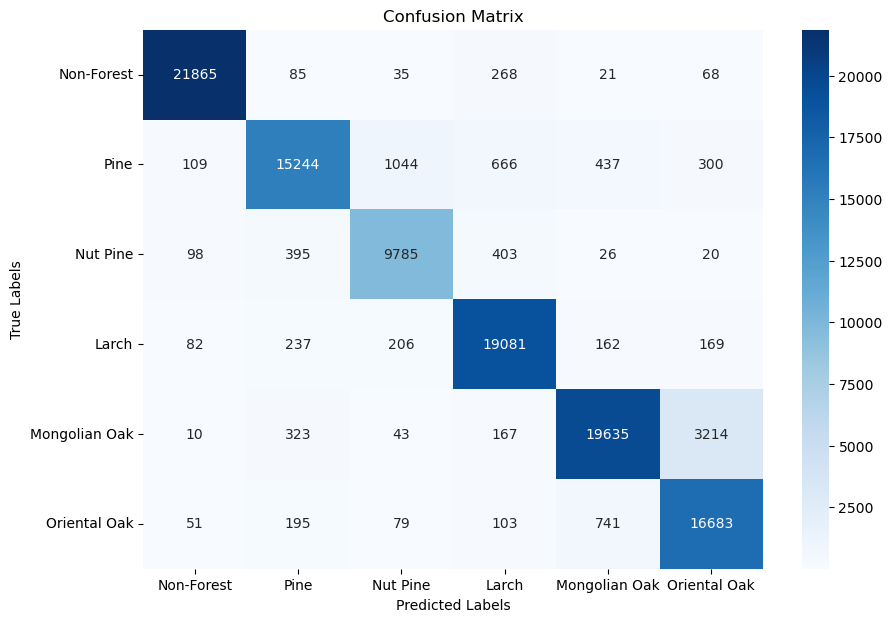

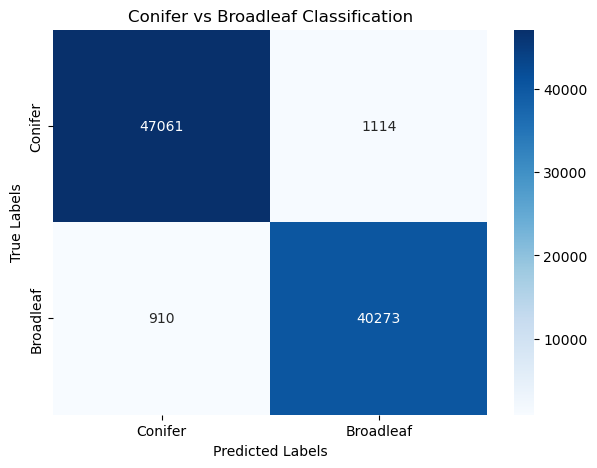

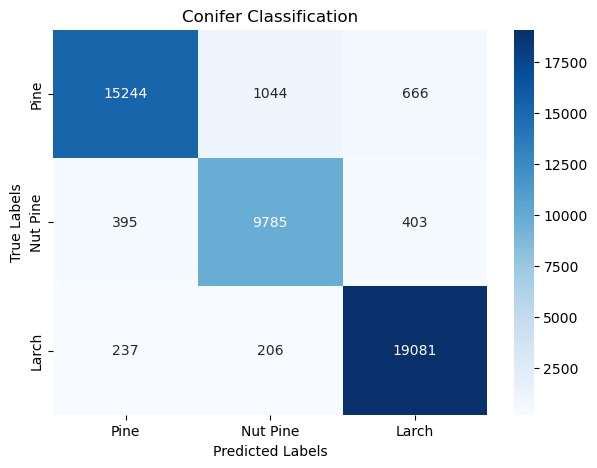

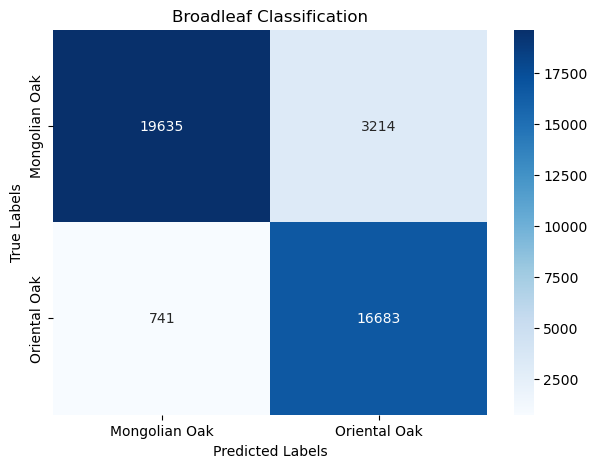


validation data


Evaluation Progress: 100%|██████████████████████████████████████████████████| 1207/1207 [00:09<00:00, 127.31it/s]


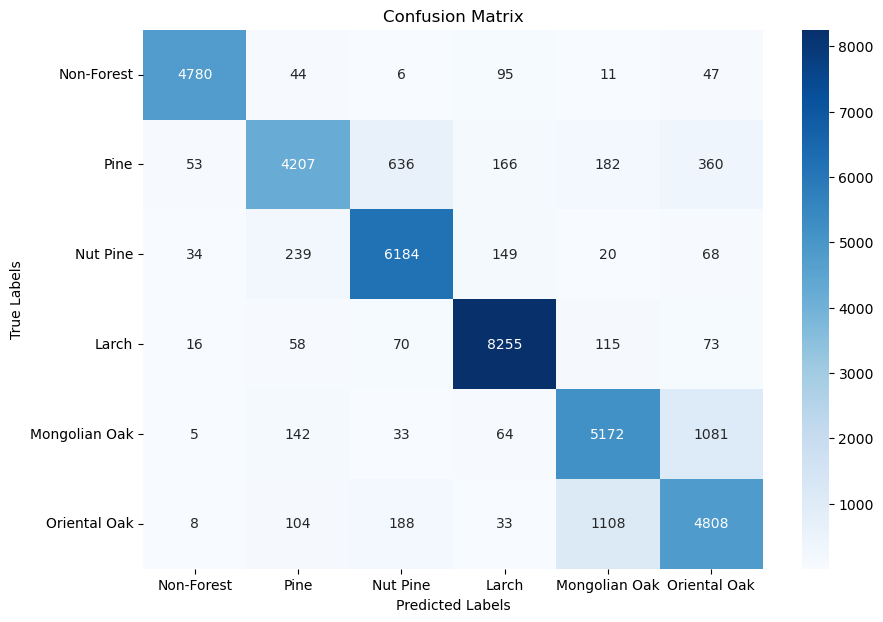

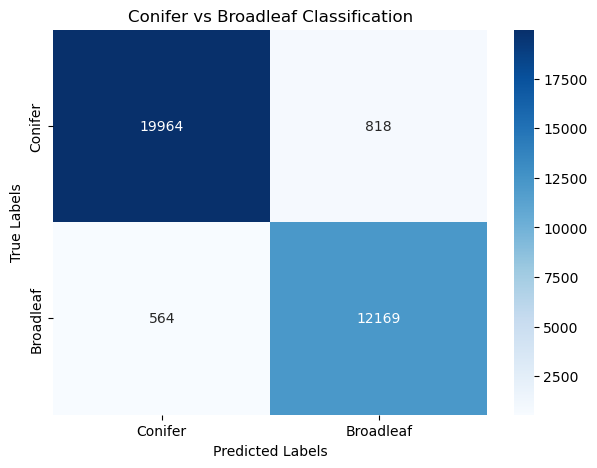

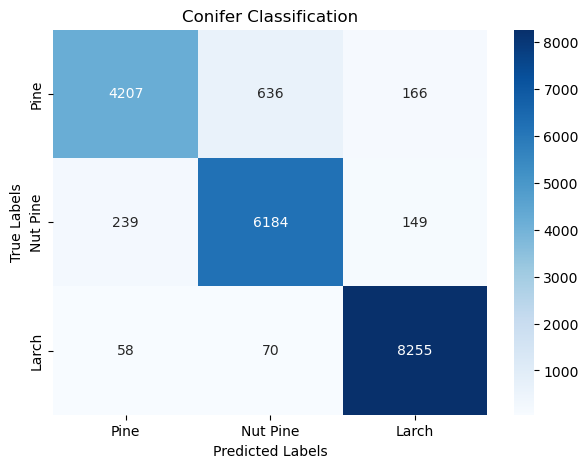

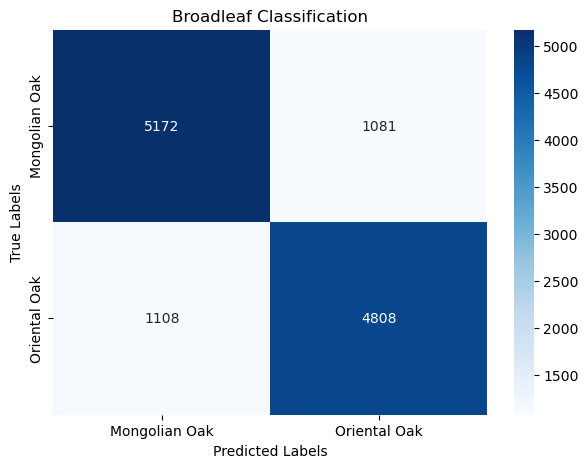

,precision,recall,f1-score,support,Category
Non-Forest,0.976307,0.959261,0.967709,4983.000000,Overall
Pine,0.877555,0.750714,0.809194,5604.000000,Overall
Nut Pine,0.868905,0.923812,0.895518,6694.000000,Overall
Larch,0.942136,0.961337,0.951640,8587.000000,Overall
Mongolian Oak,0.782688,0.796060,0.789317,6497.000000,Overall
Oriental Oak,0.746932,0.769403,0.758001,6249.000000,Overall
accuracy,0.865127,0.865127,0.865127,0.865127,Overall
macro avg,0.865754,0.860098,0.861897,38614.000000,Overall
weighted avg,0.866060,0.865127,0.864663,38614.000000,Overall
Conifer,0.972525,0.960639,0.966546,20782.000000,Conifer vs Broadleaf


In [59]:
num_epochs = 30

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100)
os.makedirs("./checkpoints/transformer", exist_ok=True)
torch.save(best_model_state, f"./checkpoints/transformer/transformer_{bands}_{patch_size}_{num_epochs}.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

파라메터 수를 올려보자

In [74]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, patch_size=9, num_bands=4, temp=12, num_classes=6, 
                 d_model=12, nhead=4, num_layers=14, dropout=0.2):
        super().__init__()
        self.patch_size = patch_size
        self.num_bands = num_bands
        self.temp = temp
        self.num_tokens = num_bands * patch_size * patch_size  # 4×81 = 324
        self.d_model = d_model  # 🔥 기존 48 → **16**으로 조정

        # Positional Encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, d_model))

        # Transformer Encoder (적절한 크기로 조정)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead,  
            dropout=dropout,  
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification Head (적절한 크기로 조정)
        self.fc = nn.Sequential(
            nn.Linear(self.num_tokens * d_model, 256),  # 🔥 기존 1024 → 256
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),  # 🔥 기존 512 → 128
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        """
        x shape: (batch, bands=4, temp=12, height=9, width=9)
        """
        batch_size = x.shape[0]

        # (batch, 4, 12, 9, 9) → (batch, 4×9×9, 12)
        x = x.view(batch_size, self.num_tokens, -1)  

        # Add Positional Encoding
        x = x + self.pos_embedding  

        # Transformer Encoder
        x = self.transformer(x)  

        # Flatten & Classification
        x = x.flatten(1)  # (batch, 324×16)
        x = self.fc(x)  # (batch, num_classes)

        return x

In [75]:
model = TransformerModel(patch_size=9, num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()

lr = 1e-4
weight_decay = 1e-4  # 🔥 L2 Regularization 적용
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Transformer 모델 파라미터 개수: {total_params}")

Transformer 모델 파라미터 개수: 1759518


In [76]:
num_epochs = 30

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100)
os.makedirs("./checkpoints/transformer", exist_ok=True)
torch.save(best_model_state, f"./checkpoints/transformer/transformer_{bands}_{patch_size}_{num_epochs}.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

Epoch 1/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [01:16<00:00, 15.73it/s]



Epoch [1/30], Train Loss: 1.7714, Train Accuracy: 20.24%, Val Loss: 1.8199, Val Accuracy: 16.83%



Epoch 2/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [01:16<00:00, 15.74it/s]



Epoch [2/30], Train Loss: 1.7681, Train Accuracy: 20.59%, Val Loss: 1.8160, Val Accuracy: 16.83%



Epoch 3/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [01:16<00:00, 15.81it/s]



Epoch [3/30], Train Loss: 1.7658, Train Accuracy: 20.76%, Val Loss: 1.8269, Val Accuracy: 16.83%



Epoch 4/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [01:16<00:00, 15.78it/s]



Epoch [4/30], Train Loss: 1.7656, Train Accuracy: 20.83%, Val Loss: 1.8270, Val Accuracy: 16.83%



Epoch 5/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [01:18<00:00, 15.42it/s]



Epoch [5/30], Train Loss: 1.7655, Train Accuracy: 20.82%, Val Loss: 1.8266, Val Accuracy: 16.83%



Epoch 6/30 - Validation:  70%|█████████████████████████████████▌              | 843/1207 [00:53<00:23, 15.69it/s]


KeyboardInterrupt: 

hybrid

In [5]:
import torch
import torch.nn as nn

class HybridCNNTransformer(nn.Module):
    def __init__(self, patch_size=9, num_bands=4, temp=12, num_classes=6, 
                 d_model=64, nhead=4, num_layers=4, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.patch_size = patch_size
        self.num_bands = num_bands
        self.temp = temp
        self.num_tokens = temp  # 12개 (시계열 단위)
        self.d_model = d_model  

        # ** 2+1D CNN Feature Extractor **
        self.cnn_feature_extractor = nn.Sequential(
            nn.Conv3d(in_channels=num_bands, out_channels=32, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(in_channels=32, out_channels=d_model, kernel_size=(3, 1, 1), padding=(1, 0, 0)),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((self.num_tokens, 1, 1))  # (B, d_model, 12, 1, 1)
        )

        # Positional Encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, d_model))

        # Layer Normalization
        self.norm1 = nn.LayerNorm(d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification Head
        self.fc = nn.Sequential(
            nn.Linear(self.num_tokens * d_model, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

        self.norm2 = nn.LayerNorm(num_classes)

        self.apply(self._init_weights)

    def forward(self, x):
        batch_size = x.shape[0]

        # CNN Feature Extraction (B, 4, 12, 9, 9) -> (B, d_model, 12, 1, 1)
        x = self.cnn_feature_extractor(x)
        x = x.squeeze(-1).squeeze(-1)  # (B, d_model, 12)
        x = x.permute(0, 2, 1)  # (B, 12, d_model)

        # Add Positional Encoding
        x = x + self.pos_embedding

        # Transformer Encoder
        x = self.norm1(x)
        x = self.transformer(x)

        # Flatten & Classification
        x = x.flatten(1)
        x = self.fc(x)
        x = self.norm2(x)

        return x

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)


In [6]:
model = HybridCNNTransformer().to(device)

# 손실 함수 (Cross Entropy Loss)
criterion = nn.CrossEntropyLoss()

# 옵티마이저 (Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Transformer 모델 파라미터 개수: {total_params}")

Transformer 모델 파라미터 개수: 251570


In [14]:
num_epochs = 30

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100)
os.makedirs("./checkpoints/hybrid", exist_ok=True)
torch.save(best_model_state, f"./checkpoints/hybrid/hybrid_{bands}_{patch_size}_{num_epochs}.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

Epoch 1/30 - Validation: 100%|████████████████████████████| 1207/1207 [00:11<00:00, 104.69it/s]



Epoch [1/30], Train Loss: 0.8846, Train Accuracy: 68.98%, Val Loss: 0.6154, Val Accuracy: 80.77%



Epoch 2/30 - Validation: 100%|█████████████████████████████| 1207/1207 [00:12<00:00, 99.76it/s]



Epoch [2/30], Train Loss: 0.5884, Train Accuracy: 80.74%, Val Loss: 0.5672, Val Accuracy: 80.29%



Epoch 3/30 - Validation: 100%|████████████████████████████| 1207/1207 [00:11<00:00, 105.56it/s]



Epoch [3/30], Train Loss: 0.5005, Train Accuracy: 83.06%, Val Loss: 0.5204, Val Accuracy: 82.97%



Epoch 4/30 - Validation: 100%|████████████████████████████| 1207/1207 [00:11<00:00, 103.06it/s]



Epoch [4/30], Train Loss: 0.4512, Train Accuracy: 84.50%, Val Loss: 0.5390, Val Accuracy: 81.77%



Epoch 5/30 - Validation: 100%|████████████████████████████| 1207/1207 [00:11<00:00, 108.70it/s]



Epoch [5/30], Train Loss: 0.4187, Train Accuracy: 85.60%, Val Loss: 0.4748, Val Accuracy: 83.71%



Epoch 6/30 - Validation: 100%|████████████████████████████| 1207/1207 [00:11<00:00, 103.80it/s]



Epoch [6/30], Train Loss: 0.3919, Train Accuracy: 86.39%, Val Loss: 0.4580, Val Accuracy: 84.88%



Epoch 7/30 - Validation: 100%|████████████████████████████| 1207/1207 [00:11<00:00, 109.06it/s]



Epoch [7/30], Train Loss: 0.3710, Train Accuracy: 87.23%, Val Loss: 0.4626, Val Accuracy: 84.84%



Epoch 8/30 - Validation: 100%|████████████████████████████| 1207/1207 [00:11<00:00, 103.34it/s]



Epoch [8/30], Train Loss: 0.3498, Train Accuracy: 87.97%, Val Loss: 0.4694, Val Accuracy: 84.68%



Epoch 9/30 - Validation: 100%|████████████████████████████| 1207/1207 [00:11<00:00, 104.77it/s]



Epoch [9/30], Train Loss: 0.3309, Train Accuracy: 88.71%, Val Loss: 0.4436, Val Accuracy: 84.82%



Epoch 10/30 - Validation: 100%|███████████████████████████| 1207/1207 [00:11<00:00, 106.63it/s]



Epoch [10/30], Train Loss: 0.3136, Train Accuracy: 89.22%, Val Loss: 0.4568, Val Accuracy: 84.81%



Epoch 11/30 - Validation: 100%|███████████████████████████| 1207/1207 [00:11<00:00, 102.53it/s]



Epoch [11/30], Train Loss: 0.3003, Train Accuracy: 89.82%, Val Loss: 0.4697, Val Accuracy: 84.83%



Epoch 12/30 - Validation: 100%|███████████████████████████| 1207/1207 [00:11<00:00, 102.32it/s]



Epoch [12/30], Train Loss: 0.2876, Train Accuracy: 90.37%, Val Loss: 0.4423, Val Accuracy: 85.69%



Epoch 13/30 - Validation: 100%|███████████████████████████| 1207/1207 [00:11<00:00, 106.66it/s]



Epoch [13/30], Train Loss: 0.2768, Train Accuracy: 90.67%, Val Loss: 0.4764, Val Accuracy: 85.60%



Epoch 14/30 - Validation: 100%|███████████████████████████| 1207/1207 [00:11<00:00, 106.96it/s]



Epoch [14/30], Train Loss: 0.2674, Train Accuracy: 90.97%, Val Loss: 0.4404, Val Accuracy: 86.05%



Epoch 15/30 - Validation: 100%|███████████████████████████| 1207/1207 [00:11<00:00, 106.81it/s]



Epoch [15/30], Train Loss: 0.2573, Train Accuracy: 91.32%, Val Loss: 0.4765, Val Accuracy: 85.65%



Epoch 16/30 - Validation: 100%|███████████████████████████| 1207/1207 [00:11<00:00, 108.88it/s]



Epoch [16/30], Train Loss: 0.2487, Train Accuracy: 91.66%, Val Loss: 0.4546, Val Accuracy: 86.33%



Epoch 17/30 - Validation: 100%|███████████████████████████| 1207/1207 [00:11<00:00, 107.63it/s]



Epoch [17/30], Train Loss: 0.2410, Train Accuracy: 91.82%, Val Loss: 0.4916, Val Accuracy: 85.15%



Epoch 18/30 - Validation: 100%|███████████████████████████| 1207/1207 [00:11<00:00, 105.06it/s]



Epoch [18/30], Train Loss: 0.2340, Train Accuracy: 92.08%, Val Loss: 0.4722, Val Accuracy: 86.03%



Epoch 19/30 - Validation: 100%|███████████████████████████| 1207/1207 [00:11<00:00, 107.47it/s]



Epoch [19/30], Train Loss: 0.2259, Train Accuracy: 92.40%, Val Loss: 0.4821, Val Accuracy: 85.47%



Epoch 20/30 - Validation: 100%|████████████████████████████| 1207/1207 [00:12<00:00, 99.66it/s]



Epoch [20/30], Train Loss: 0.2225, Train Accuracy: 92.46%, Val Loss: 0.5216, Val Accuracy: 84.89%



Epoch 21/30 - Training:  20%|██████▏                        | 701/3502 [00:15<01:03, 43.87it/s]


KeyboardInterrupt: 

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

# ✅ Depthwise 2+1D CNN Feature Extractor
class ConvFeatureExtractor(nn.Module):
    def __init__(self, in_channels=4, hidden_dim=12):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, hidden_dim, kernel_size=(1, 3, 3), padding=(0, 1, 1))
        self.bn1 = nn.BatchNorm3d(hidden_dim)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv3d(hidden_dim, hidden_dim * 2, kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.bn2 = nn.BatchNorm3d(hidden_dim * 2)
        
        self.conv3 = nn.Conv3d(hidden_dim * 2, hidden_dim * 4, kernel_size=(1, 3, 3), padding=(0, 1, 1))
        self.bn3 = nn.BatchNorm3d(hidden_dim * 4)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x  # (batch, 48, 12, 9, 9)

# ✅ Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=12):
        super().__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channels, _, _, _ = x.shape
        se_weight = self.global_avg_pool(x).view(batch, channels)
        se_weight = self.fc(se_weight).view(batch, channels, 1, 1, 1)
        return x * se_weight

# ✅ Transformer Encoder
class TransformerModel(nn.Module):
    def __init__(self, d_model=48, num_heads=2, num_layers=1, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 6)  # Output 6 classes
    
    def forward(self, x):
        x = self.transformer(x)  # (batch, seq_len, d_model)
        x = x.mean(dim=1)  # Global Average Pooling
        x = self.fc(x)
        return x

# ✅ Hybrid Model
class HybridCNNTransformer(nn.Module):
    def __init__(self, in_channels=4, num_classes=6):
        super().__init__()
        self.cnn = ConvFeatureExtractor(in_channels, hidden_dim=12)
        self.se = SEBlock(48)
        self.transformer = TransformerModel(d_model=48)

    def forward(self, x):
        x = self.cnn(x)  # CNN Feature Extraction
        x = self.se(x)  # SE Attention
        x = x.flatten(2).permute(0, 2, 1)  # (batch, 12, 48)
        x = self.transformer(x)  # Transformer 처리
        return x

In [14]:
# ✅ Model Initialization
model = HybridCNNTransformer(in_channels=4, num_classes=6).cuda()

# ✅ Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Transformer 모델 파라미터 개수: {total_params}")

Transformer 모델 파라미터 개수: 220950


In [15]:
num_epochs = 30

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100)
# os.makedirs("./checkpoints/hybrid", exist_ok=True)
# torch.save(best_model_state, f"./checkpoints/hybrid/hybrid_{bands}_{patch_size}_{num_epochs}.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

Epoch 1/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:18<00:00, 65.24it/s]



Epoch [1/30], Train Loss: 0.7421, Train Accuracy: 71.84%, Val Loss: 0.8974, Val Accuracy: 67.60%



Epoch 2/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:18<00:00, 63.70it/s]



Epoch [2/30], Train Loss: 0.4983, Train Accuracy: 80.86%, Val Loss: 0.9578, Val Accuracy: 66.97%



Epoch 3/30 - Validation: 100%|███████████████████████████████████████████████| 1207/1207 [00:19<00:00, 62.71it/s]



Epoch [3/30], Train Loss: 0.4374, Train Accuracy: 83.31%, Val Loss: 0.9972, Val Accuracy: 65.51%



Epoch 4/30 - Training:  56%|███████████████████████████▍                     | 1965/3502 [01:19<01:02, 24.66it/s]


KeyboardInterrupt: 